In [1]:
import os
import json

import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%load_ext autoreload
%autoreload 2

from TrainLoop.trainer import Trainer
from archs.unet import UNetConvNext
from TrainLoop.data import SemanticSegmentationCOCODataset, ConvNextPreprocessor, ConvNextPreprocessorNumpy
from TrainLoop.utils import one_hot_labels
from TrainLoop.metrics import MeanIOU

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/jupyter/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
convnext = timm.create_model('convnextv2_femto', checkpoint_path = './models/convnextv2_femto.safetensors')

In [3]:
size = (768,768)
preprocessor = ConvNextPreprocessor(size, use_imagenet_norm=False)

subset = 'Train'
ds_train = SemanticSegmentationCOCODataset(f'../yolo/datasets/damages_1k_v3_enlarge1_reshaffle_coco/{subset}','instances_Train.json', preprocessor)
subset = 'Validation'
ds_val = SemanticSegmentationCOCODataset(f'../yolo/datasets/damages_1k_v3_enlarge1_reshaffle_coco/{subset}','instances_Validation.json', preprocessor)
subset = 'Test'
ds_test = SemanticSegmentationCOCODataset(f'../yolo/datasets/damages_1k_v3_enlarge1_reshaffle_coco/{subset}','instances_Test.json', preprocessor)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=2)

id2label = {v['id']: v['name'] for _,v in ds_train.coco_dataset.cats.items()}
id2label[0] = 'фон'
label2id = {name: id_ for id_, name in id2label.items()}
label2id

{'стекло разрушение': 1,
 'смещение': 2,
 'вмятина': 3,
 'лкп': 4,
 'пробой': 5,
 'разрушение': 6,
 'фара разрушение': 7,
 'отсутствие': 8,
 'фон': 0}

## Unet

In [5]:
id2label

{1: 'стекло разрушение',
 2: 'смещение',
 3: 'вмятина',
 4: 'лкп',
 5: 'пробой',
 6: 'разрушение',
 7: 'фара разрушение',
 8: 'отсутствие',
 0: 'фон'}

In [6]:
n_epochs = 40

unet = UNetConvNext(convnext, n_classes=len(label2id))
optimizer = torch.optim.AdamW(unet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

def ce_loss(pred, labels):
    labels = labels.unsqueeze(1)
    labels = nn.functional.interpolate(labels.type(torch.FloatTensor),
            size=pred.shape[2:], # (height, width)
            mode='bilinear',
            align_corners=False).type(torch.LongTensor).to(device).squeeze()
    return torch.nn.functional.cross_entropy(pred, labels)


mean_iou = MeanIOU(num_labels=len(id2label), mode='accum')

def accum_iou_callback(preds, labels):
    preds = np.argmax(torch.softmax(preds.cpu(), dim=1).numpy(), axis=1)
    labels = nn.functional.interpolate(labels.unsqueeze(1).type(torch.FloatTensor),
                size=preds.shape[1:], # (height, width)
                mode='nearest').squeeze(1).numpy()
    mean_iou.compute(preds, labels)

def compute_iou_callback(save_dir, iteration):
    res = mean_iou.get_results()
    for i_label, iou in enumerate(res['per_category_iou']):
        res[f'{id2label[i_label]}_iou'] = iou
    res.pop('per_category_iou')
    for i_label, acc in enumerate(res['per_category_accuracy']):
        res[f'{id2label[i_label]}_acc'] = acc
    res.pop('per_category_accuracy')
    res['iteration'] = iteration    
    with open(os.path.join(save_dir,'metrics.log'), 'a') as f:
            f.write(json.dumps(res, ensure_ascii=False) + '\n')

In [7]:
trainer = Trainer(model=unet,
        save_dir='run/base',
        loss_fn=ce_loss,
        optimizer=optimizer,
        scheduler=scheduler,
        n_epochs=40,
        device=device,
        early_stop_rounds=5,
        eval_strat='epoch',
        accumulate_metric_callbacks=[accum_iou_callback],
        compute_metric_callbacks=[compute_iou_callback],
        save_only_best=False)
# trainer = Trainer(model=unet,
#         save_dir='run/base',
#         loss_fn=ce_loss,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         n_steps=100,
#         n_steps_eval=5,
#         device=device,
#         early_stop_rounds=5,
#         eval_strat='step',
#         accumulate_metric_callbacks=[accum_iou_callback],
#         compute_metric_callbacks=[compute_iou_callback],
#         save_only_best=False)

In [8]:
trainer.train(dl_train, dl_val)

Batch: 63:  47%|████▋     | 65/137 [05:57<06:23,  5.33s/it]


Batch: 127:  94%|█████████▍| 129/137 [11:19<00:38,  4.84s/it]


Batch: 54:  41%|████      | 56/137 [04:54<07:10,  5.31s/it]


Batch: 118:  88%|████████▊ | 120/137 [10:24<01:34,  5.55s/it]


Batch: 45:  34%|███▎      | 46/137 [03:56<07:20,  4.84s/it]


Batch: 109:  81%|████████  | 111/137 [09:32<02:14,  5.17s/it]


Batch: 36:  27%|██▋       | 37/137 [03:20<08:48,  5.28s/it]


Batch: 100:  74%|███████▍  | 102/137 [09:02<03:13,  5.54s/it]


Batch: 26:  20%|██        | 28/137 [02:38<11:05,  6.11s/it]


Batch: 70:  52%|█████▏    | 71/137 [06:18<05:34,  5.07s/it]


KeyboardInterrupt: 

In [11]:
import os
import cv2
import numpy as np
model = torch.load('./models/best_Epoch_5_batch_68.pt', map_location='cpu')
reduced_labels=False

{1: 'стекло разрушение', 2: 'смещение', 3: 'вмятина', 4: 'лкп', 5: 'пробой', 6: 'разрушение', 7: 'фара разрушение', 8: 'отсутствие', 0: 'фон'}
GT labels: [(0, 'фон'), (4, 'лкп')]
Pred labels: [(0, 'фон')]


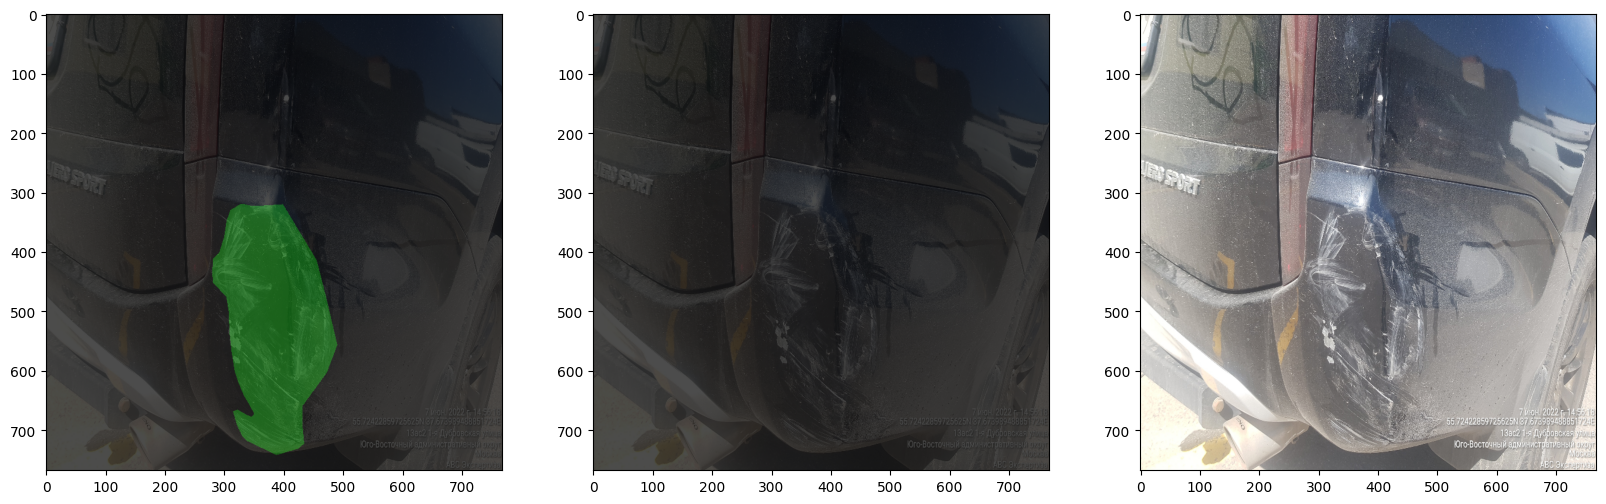

In [12]:
id2label2 = {1: 'стекло разрушение', 2: 'смещение', 3: 'вмятина', 4: 'лкп', 5: 'пробой', 
            6: 'разрушение', 7: 'фара разрушение', 8: 'отсутствие', 0: 'фон'}
print(id2label2)

ds = ds_test

i_img = 15
thr = 0.95
img_path = os.path.join(ds.root_dir, ds.coco_dataset.imgs[ds.idx_mapper[i_img]]['file_name'])
orig_img = cv2.imread(img_path)[:,:,::-1]
orig_img = cv2.resize(orig_img, (768,768))
if reduced_labels:
    gt = ds[i_img][1].detach().numpy().astype(np.uint8)
else:
    gt = ds[i_img][1].detach().numpy().astype(np.uint8)
print('GT labels:', [(idx, id2label2[idx]) for idx in np.unique(gt)])
x = ds[i_img][0].unsqueeze(0)
with torch.no_grad():
    model.eval()
    outputs = model(x)
logits = outputs.detach().cpu()
probs = torch.sigmoid(nn.functional.interpolate(logits,
                size=orig_img.shape[:2], # (height, width)
                mode='bilinear',
                align_corners=False)[0]).numpy()
if reduced_labels:
    pred_label = np.argmax(np.concatenate([np.zeros((1, *probs.shape[1:]), dtype=np.float32) + thr,
                                           np.where(probs > thr, probs, 0)], axis=0), axis=0)
else:
    pred_label = np.argmax(probs, axis=0)
print('Pred labels:', [(idx, id2label2[idx]) for idx in np.unique(pred_label)])

id2color = {0: [0, 0, 0], 1: [200, 0, 0], 2: [108, 64, 20], 3: [255, 229, 204], 4: [0, 102, 0], 5: [0, 255, 0], 6: [0, 153, 153], 7: [0, 128, 255], 8: [255, 255, 0]}
color_seg = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[gt == label, :] = color


f, ax = plt.subplots(1,3, figsize=(20,7))

color_seg = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[gt == label, :] = color

ax[0].imshow((color_seg*0.7 + orig_img*0.3).astype(np.uint8))
color_seg = np.zeros((pred_label.shape[0], pred_label.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[pred_label == label, :] = color
ax[1].imshow((color_seg*0.7 + orig_img*0.3).astype(np.uint8))
ax[2].imshow(orig_img)
# thr = 0.9
# img_path = os.path.join(ds_test.root_dir, ds_test.coco_dataset.imgs[ds_test.idx_mapper[i_img]]['file_name'])
# image = Image.open(img_path)
# # First, rescale logits to original image size
# upsampled_logits = nn.functional.interpolate(logits,
#                 size=image.size[::-1], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)

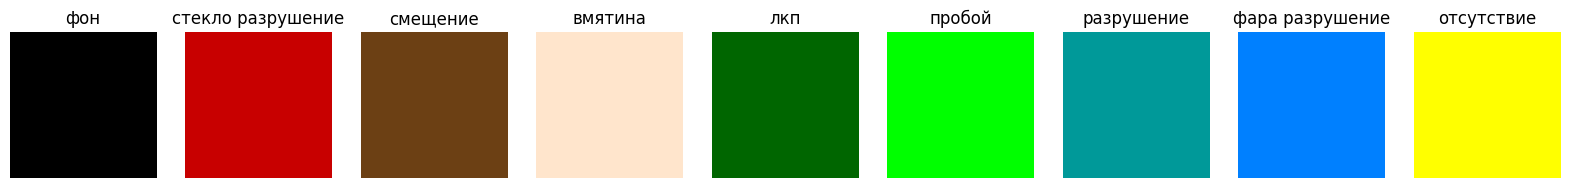

In [13]:
f, ax = plt.subplots(1,len(id2color), figsize=(20,6))
for i in range(len(id2color)):
    ax[i].imshow((np.zeros((4,4,3)) + id2color[i])/255)
    ax[i].set_title(id2label2[i])
    ax[i].axis('off')

0.42731923

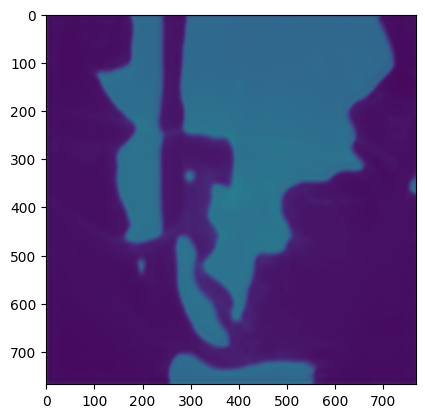

In [14]:
i = 2
plt.imshow(probs[i], vmin=0, vmax=1)
probs[i].max()

In [42]:
mean_iou = MeanIOU(mode='accum')

In [45]:
mean_iou.compute_mean_iou([pred_label,pred_label], [gt,gt], num_labels=9, ignore_index=0)

In [46]:
mean_iou.get_results()

/home/jupyter/data/dbatsula/YADRO2/damage_rec_modelling/Custom/TrainLoop/metrics/mean_iou.py:189: RuntimeWarning: invalid value encountered in divide
  iou = self.total_area_intersect / self.total_area_union
/home/jupyter/data/dbatsula/YADRO2/damage_rec_modelling/Custom/TrainLoop/metrics/mean_iou.py:190: RuntimeWarning: invalid value encountered in divide
  acc = self.total_area_intersect / self.total_area_label


{'mean_iou': 0.0,
 'mean_accuracy': 0.0,
 'overall_accuracy': 0.0,
 'per_category_iou': array([ 0., nan, nan, nan,  0., nan, nan, nan, nan]),
 'per_category_accuracy': array([nan, nan, nan, nan,  0., nan, nan, nan, nan])}

In [130]:
pred_label.max()

0

In [116]:
x = 10*torch.tensor([[[0.9,0.1],[0.9,0.1]], [[0.7, 0.85],[0.02,0.2]], [[0.1,0.05],[0.08, 0.7]]])[None]
y = torch.tensor([[1,1],[0,2]]).reshape(1,2,2)
torch.nn.functional.cross_entropy(x,y)

tensor(0.5344)

In [ ]:
torch.nn.CrossEntropyLoss()